In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
import plotly.express as px
from rulefit import RuleFit
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import itertools
import pandas as pd
from tqdm import tqdm
from utils import *
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

Load dataset

In [2]:
chosen_features = None
dataset = pkl.load(open('./bankrupcy.pkl', 'rb'))
y_all = dataset['y']
if 'Shell weight' in dataset['num_names']:
    y_all = (y_all > 9).astype(int)
elif 'num_procedures' in dataset['num_names']:
    y_all = (y_all > 0).astype(int)
X = np.concatenate([dataset['X_num'], dataset['X_cat']], -1)
baseline = return_baseline(dataset['X_num'], dataset['X_cat'])
feature_names = np.concatenate([dataset['num_names'], dataset['cat_names']])
if chosen_features is None:
    chosen_features = np.arange(len(X[0]))
X_all = X[:, chosen_features]
baseline = baseline[chosen_features]
features = np.array(['X{}'.format(str(i).zfill(3)) for i in range(X_all.shape[-1])])
features_dic = {'X{}'.format(str(i).zfill(3)): feature_names[chosen_features[i]] for i in range(X_all.shape[-1])}
fn = ['\n'.join(['-\n'.join([j[:7], j[7:]])  if len(j)>7 else j for j in i.split('\n')]) for i in feature_names]

In [3]:
pd.DataFrame(X, columns=feature_names).head()

,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,...,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets
0,0.200550,0.37951,0.396410,2.0472,32.351,0.388250,0.249760,1.33050,1.1389,0.50494,...,348690.0000,0.121960,0.397180,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.42770
1,0.009020,0.63202,0.053735,1.1263,-37.842,0.000000,0.014434,0.58223,1.3332,0.36798,...,1.1263,0.180110,0.024512,0.84165,0.340940,9.9665,4.2382,116.500,3.1330,2.56030
2,0.266690,0.34994,0.611470,3.0243,43.087,0.559830,0.332070,1.85770,1.1268,0.65006,...,5340.0000,0.112500,0.410250,0.88750,0.073630,9.5593,5.6298,38.168,9.5629,33.41300
3,0.067731,0.19885,0.081562,2.9576,90.606,0.212650,0.078063,4.02900,1.2570,0.80115,...,15132.0000,0.204440,0.084542,0.79556,0.196190,8.2122,2.7917,60.218,6.0613,0.28803
4,-0.029182,0.21131,0.452640,7.5746,57.844,0.010387,-0.034653,3.73240,1.0241,0.78869,...,34549.0000,0.023565,-0.037001,0.97644,0.180630,3.4646,11.3380,31.807,11.4750,1.65110


Train test split

In [4]:
balanced = True ## To balance dataset between labels
npoints = None

In [5]:
if balanced:
    X_all, y_all = balanced_dataset(X_all, y_all, max_size=10000)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all)
print(len(X_all))

864


## Rulefit

In [8]:
from featurevec import FeatureVec

In [9]:
fv = FeatureVec('classify', max_depth=3, max_sentences=100000, 
                feature_names=list(feature_names),
                exp_rand_tree_size=False,
               tree_generator=None)
fv.fit(X_train, y_train, bagging=5)
print(fv.predictor.score(X_test, y_test)) ## Model accuracy

In [12]:
fv.plot(dynamic=True, confidence=True, path='image_dir/bankrupcy.html')

## Different feature importance methods

In [13]:
num_rmvs = min(X.shape[-1], 20)
rf_order = np.argsort(fv.predictor.feature_importances_)[::-1]
fv_order = np.argsort(fv.importance)[::-1]
pm_order = np.argsort(permutation_importance(fv.predictor, X_train, y_train, n_repeats=1)['importances_mean'])[::-1]

drop_rf = accuracy_drop(rf_order[:20], fv.predictor, X_train, y_train, X_test, y_test)
drop_fv = accuracy_drop(fv_order[:20], fv.predictor, X_train, y_train, X_test, y_test)
drop_pm = accuracy_drop(pm_order[:20], fv.predictor, X_train, y_train, X_test, y_test)
drop_rnd = np.mean([
        accuracy_drop(np.random.permutation(X_train.shape[-1])[:20], fv.predictor, X_train, y_train, X_test, y_test)
        for _ in range(1)], 0)

100%|██████████| 20/20 [07:54<00:00, 23.70s/it]


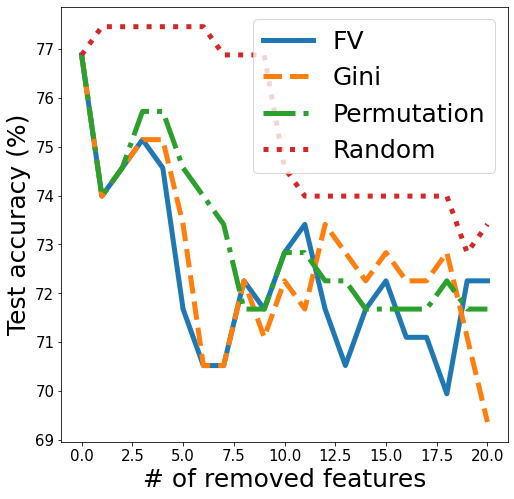

In [14]:
fig = plt.figure(figsize=(8,8))
plt.rcParams['font.size'] = 15
plt.plot(np.arange(len(drop_fv)), 100 * np.array(drop_fv),  lw=5)
plt.plot(np.arange(len(drop_rf)), 100 * np.array(drop_rf), ls='--', lw=5)
plt.plot(np.arange(len(drop_pm)), 100 * np.array(drop_pm), ls='-.', lw=5)
plt.plot(np.arange(len(drop_rnd)), 100 * np.array(drop_rnd), ls='dotted', lw=5)
plt.xlabel('# of removed features', fontsize=25)
plt.ylabel('Test accuracy (%)', fontsize=25)
plt.legend(['FV', 'Gini', 'Permutation', 'Random'], fontsize=25)